## Metro Bike Share Analysis
### Author: Rony Guerra Jr

## Introduction

The dataset captures Los Angeles metro bike trip details spanning several quarters, offering a deep dive into the commuting patterns of bike-share riders. Each record in the dataset  corresponds to an individual metro bike trip, capturing details that narrate the journey of a commuter.

The objective of the analysis is to utilize LA metro bike trip data to identify current demand patterns, spotlight underserved areas, and recommend potential locations for new metro stations based on actual commuter needs. 

In [1]:
# import libraries
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import geopandas as gpd
from selenium import webdriver
from shapely.geometry import Point
from folium.plugins import HeatMap
import folium.plugins as plugins
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
from scipy.spatial import distance
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
# displays all of the columns in dataframes
pd.set_option('display.max_columns', None)

In [2]:
pwd

'C:\\Users\\User\\OneDrive\\Portfolio Projects\\Metro Bike Share'

In [3]:
# Use glob to get a list of all CSV files
csv_files = glob.glob("metro-trips-20[1-2][0-9]-q[1-4].csv")

# Use a list comprehension to read each file into a DataFrame
dataframes = [pd.read_csv(file) for file in csv_files]

# Concatenate all these dataframes
df = pd.concat(dataframes, ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_4292\3983138418.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes = [pd.read_csv(file) for file in csv_files]
C:\Users\User\AppData\Local\Temp\ipykernel_4292\3983138418.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes = [pd.read_csv(file) for file in csv_files]
C:\Users\User\AppData\Local\Temp\ipykernel_4292\3983138418.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes = [pd.read_csv(file) for file in csv_files]


In [4]:
df.head()

,trip_id,duration,start_time,end_time,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station,bike_type,start station name,end station name
0,1912818,3,7/7/2016 4:17,7/7/2016 4:20,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281,30.0,Round Trip,Monthly Pass,NaN,NaN,NaN,NaN,NaN
1,1919661,33,7/7/2016 6:00,7/7/2016 6:33,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281,30.0,Round Trip,Monthly Pass,NaN,NaN,NaN,NaN,NaN
2,1933383,5,7/7/2016 10:32,7/7/2016 10:37,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861,365.0,Round Trip,Flex Pass,NaN,NaN,NaN,NaN,NaN
3,1944197,181,7/7/2016 10:37,7/7/2016 13:38,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861,365.0,Round Trip,Flex Pass,NaN,NaN,NaN,NaN,NaN
4,1940317,7,7/7/2016 12:51,7/7/2016 12:58,3032.0,34.049889,-118.25588,3032.0,34.049889,-118.25588,6674,0.0,Round Trip,Walk-up,NaN,NaN,NaN,NaN,NaN


## Data Exploration

In [5]:
df.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station_id',
       'start_lat', 'start_lon', 'end_station_id', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'start_station', 'end_station', 'bike_type', 'start station name',
       'end station name'],
      dtype='object')

In [6]:
df.shape

(1833074, 19)

The dataset has 1,833,074 rows and 19 columns.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1833074 entries, 0 to 1833073
Data columns (total 19 columns):
 #   Column               Dtype  
---  ------               -----  
 0   trip_id              int64  
 1   duration             int64  
 2   start_time           object 
 3   end_time             object 
 4   start_station_id     float64
 5   start_lat            float64
 6   start_lon            float64
 7   end_station_id       float64
 8   end_lat              float64
 9   end_lon              float64
 10  bike_id              object 
 11  plan_duration        float64
 12  trip_route_category  object 
 13  passholder_type      object 
 14  start_station        float64
 15  end_station          float64
 16  bike_type            object 
 17  start station name   object 
 18  end station name     object 
dtypes: float64(9), int64(2), object(8)
memory usage: 265.7+ MB


In [8]:
df.describe()

,trip_id,duration,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,plan_duration,start_station,end_station
count,1.833074e+06,1.833074e+06,89225.000000,1.822821e+06,1.822821e+06,89225.000000,1.789488e+06,1.789487e+06,1.832690e+06,1.743849e+06,1.743849e+06
mean,1.348581e+08,3.672589e+01,3042.989644,3.404173e+01,-1.182743e+02,3042.444068,3.404127e+01,-1.182718e+02,4.700874e+01,3.649913e+03,3.636584e+03
std,6.828561e+07,1.198024e+02,41.420004,3.153038e-01,2.066633e+00,47.273035,3.288584e-01,2.183594e+00,9.601830e+01,6.609304e+02,6.594604e+02
min,1.912818e+06,1.000000e+00,3000.000000,0.000000e+00,-1.184954e+02,3000.000000,0.000000e+00,-1.184954e+02,0.000000e+00,3.000000e+03,3.000000e+03
25%,9.244653e+07,7.000000e+00,3024.000000,3.402835e+01,-1.183092e+02,3022.000000,3.402765e+01,-1.183091e+02,1.000000e+00,3.034000e+03,3.032000e+03
50%,1.339453e+08,1.400000e+01,3038.000000,3.404613e+01,-1.182601e+02,3038.000000,3.404607e+01,-1.182591e+02,3.000000e+01,3.076000e+03,3.075000e+03
75%,1.814442e+08,2.700000e+01,3063.000000,3.405194e+01,-1.182484e+02,3063.000000,3.405091e+01,-1.182483e+02,3.000000e+01,4.285000e+03,4.273000e+03
max,2.797237e+08,1.440000e+03,4108.000000,5.570553e+01,1.182383e+02,4108.000000,5.570553e+01,1.182857e+02,9.990000e+02,4.655000e+03,4.656000e+03


In [9]:
unique_bike_id = df['bike_id'].nunique()
unique_bike_id

8607

There is 8607 unique bikes.

In [10]:
# unique_station_id = df['start_station_id'].nunique()

In [11]:
nunique_bike_type = df['bike_type'].nunique()
unique_bike_type = df['bike_type'].unique()
nunique_bike_type, unique_bike_type

(3, array([nan, 'standard', 'electric', 'smart'], dtype=object))

There is 3 unique bike types: standard electric, and smart.

In [12]:
# identifies the number of unique vales for stations
nunique_start_station = df['start_station'].nunique()
nunique_end_station = df['end_station'].nunique()
nunique_start_station, nunique_end_station

(404, 413)

404 metro start stations and 413 metro end stations across LA county.

## Data Cleaning 
## Handling Missing Values

In [13]:
# calculates the number of missing values in each column
missing_values = df.isnull().sum()
missing_values

trip_id                      0
duration                     0
start_time                   0
end_time                     0
start_station_id       1743849
start_lat                10253
start_lon                10253
end_station_id         1743849
end_lat                  43586
end_lon                  43587
bike_id                      0
plan_duration              384
trip_route_category          0
passholder_type           4885
start_station            89225
end_station              89225
bike_type               565919
start station name     1773993
end station name       1773993
dtype: int64

In [14]:
# calculate the percentage of missing values in each column
missing_values_percentage = (missing_values / len(df)) * 100
missing_values_percentage

trip_id                 0.000000
duration                0.000000
start_time              0.000000
end_time                0.000000
start_station_id       95.132493
start_lat               0.559334
start_lon               0.559334
end_station_id         95.132493
end_lat                 2.377755
end_lon                 2.377809
bike_id                 0.000000
plan_duration           0.020948
trip_route_category     0.000000
passholder_type         0.266492
start_station           4.867507
end_station             4.867507
bike_type              30.872676
start station name     96.776944
end station name       96.776944
dtype: float64

In [15]:
# drop columns with a high percentage of missing values
df.drop(columns=['start_station_id', 'end_station_id',
                 'start station name','end station name'], inplace = True)

In [16]:
# drop rows where lat and lon are missing
df.dropna(subset=['start_station', 'end_station', 
                  'start_lat','start_lon','end_lat','end_lon'], inplace = True)

In [17]:
df.isnull().sum()

trip_id                     0
duration                    0
start_time                  0
end_time                    0
start_lat                   0
start_lon                   0
end_lat                     0
end_lon                     0
bike_id                     0
plan_duration               0
trip_route_category         0
passholder_type          4759
start_station               0
end_station                 0
bike_type              468440
dtype: int64

In [18]:
# identifies unique values for categorical columns
unique_values = {
    'trip_route_category': df['trip_route_category'].unique(),
    'passholder_type': df['passholder_type'].unique(),
    'bike_type': df['bike_type'].unique()
}
unique_values

{'trip_route_category': array(['One Way', 'Round Trip'], dtype=object),
 'passholder_type': array(['Walk-up', 'Monthly Pass', 'Flex Pass', 'One Day Pass',
        'Annual Pass', 'Testing', nan], dtype=object),
 'bike_type': array([nan, 'standard', 'electric', 'smart'], dtype=object)}

Unique values for categorical columns:

trip_route_category: One Way, Round Trip

passholder_type: Walk-up, Monthly Pass, One Day Pass, Flex Pass, Annual Pass, Testing

bike_type: NaN (missing values), Standard, Electric, Smart

In [19]:
# drop rows where the passholder_type column is set to 'Testing'
df = df[df['passholder_type'] != 'Testing']

In [20]:
df.shape

(1695044, 15)

In [21]:
# fill missing bike_type values with 'Unknown'
df['bike_type'].fillna('Unknown', inplace=True)

In [22]:
df.isnull().sum()

trip_id                   0
duration                  0
start_time                0
end_time                  0
start_lat                 0
start_lon                 0
end_lat                   0
end_lon                   0
bike_id                   0
plan_duration             0
trip_route_category       0
passholder_type        4759
start_station             0
end_station               0
bike_type                 0
dtype: int64

In [23]:
# counting the unique bike IDs and unique station IDs
unique_bikes = df['bike_id'].nunique()
unique_start_stations = df['start_station'].nunique()
unique_end_stations = df['end_station'].nunique()

# Taking the union of start and end stations to get total unique stations
total_unique_stations = len(set(df['start_station']).union(set(df['end_station'])))

unique_bikes, total_unique_stations

(8355, 412)

In [24]:
df.shape

(1695044, 15)

### Data Type Conversion

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1695044 entries, 55439 to 1833073
Data columns (total 15 columns):
 #   Column               Dtype  
---  ------               -----  
 0   trip_id              int64  
 1   duration             int64  
 2   start_time           object 
 3   end_time             object 
 4   start_lat            float64
 5   start_lon            float64
 6   end_lat              float64
 7   end_lon              float64
 8   bike_id              object 
 9   plan_duration        float64
 10  trip_route_category  object 
 11  passholder_type      object 
 12  start_station        float64
 13  end_station          float64
 14  bike_type            object 
dtypes: float64(7), int64(2), object(6)
memory usage: 206.9+ MB


In [26]:
# convert start_station and end_station from float to int
df['start_station'] = df['start_station'].astype(int)
df['end_station'] = df['end_station'].astype(int)
# convert plan_duration from float to int
df['plan_duration'] = df['plan_duration'].astype(int)

In [27]:
# converts start_time and end_time to datetime format
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

In [28]:
df.dtypes

trip_id                         int64
duration                        int64
start_time             datetime64[ns]
end_time               datetime64[ns]
start_lat                     float64
start_lon                     float64
end_lat                       float64
end_lon                       float64
bike_id                        object
plan_duration                   int32
trip_route_category            object
passholder_type                object
start_station                   int32
end_station                     int32
bike_type                      object
dtype: object

### Handle Outliers

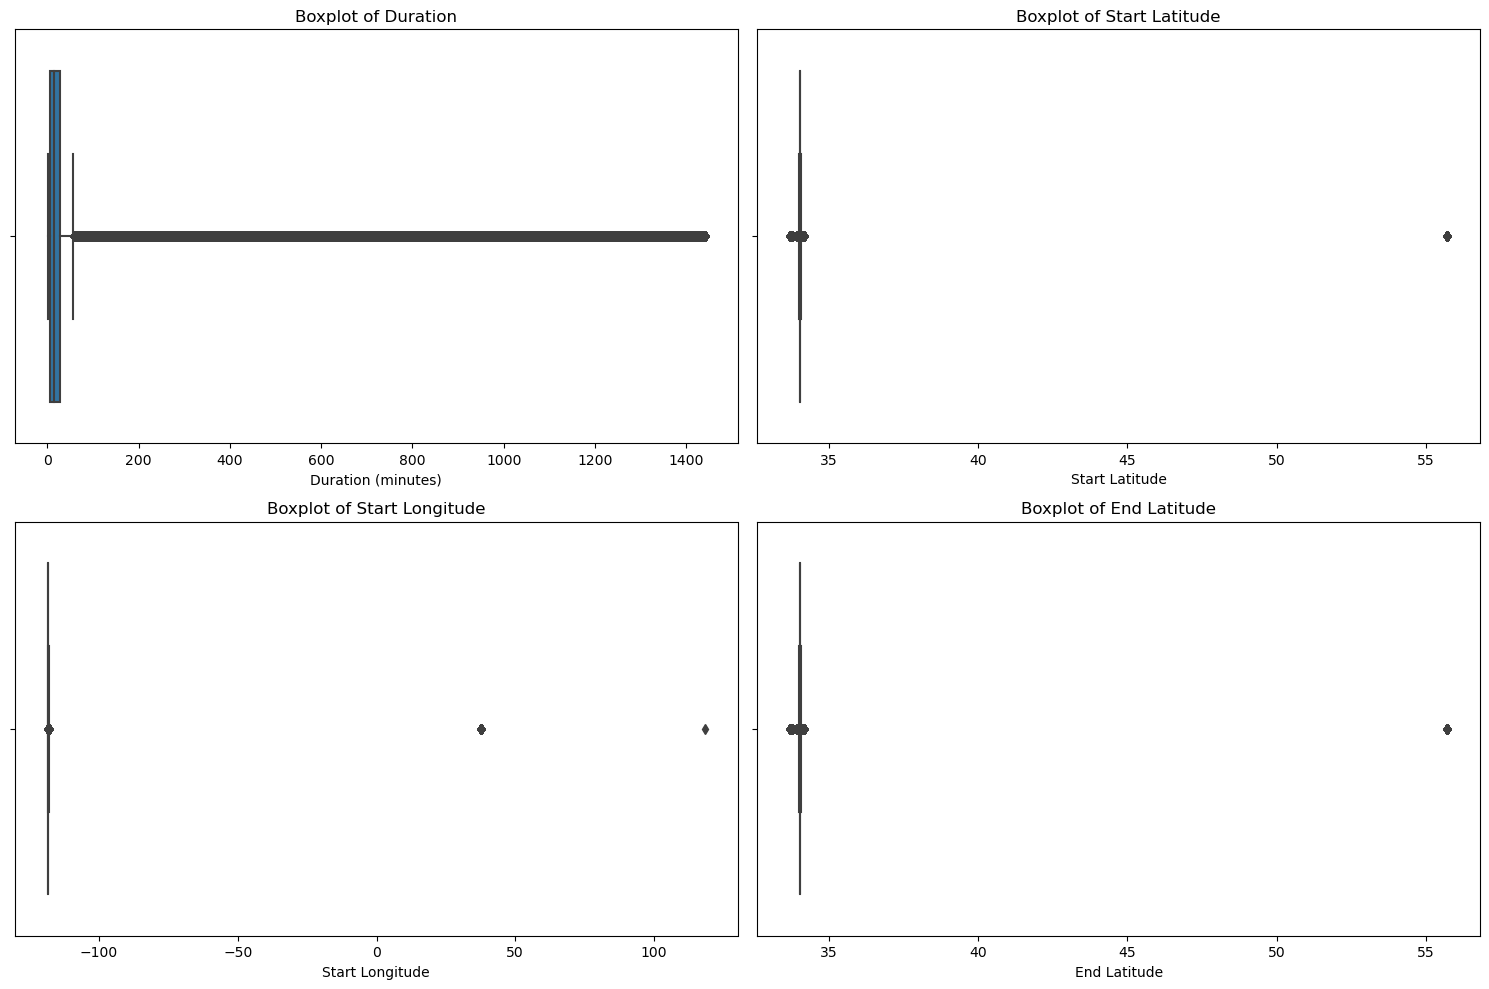

In [29]:
# identify outliers with boxplot
fig, ax = plt.subplots(2, 2, figsize=(15,10))

# boxplot for duration
sns.boxplot(x=df['duration'], ax=ax[0, 0])
ax[0, 0].set_title('Boxplot of Duration')
ax[0, 0].set_xlabel('Duration (minutes)')

# Boxplot for start_lat
sns.boxplot(x=df['start_lat'], ax=ax[0, 1])
ax[0, 1].set_title('Boxplot of Start Latitude')
ax[0, 1].set_xlabel('Start Latitude')

# Boxplot for start_lon
sns.boxplot(x=df['start_lon'], ax=ax[1, 0])
ax[1, 0].set_title('Boxplot of Start Longitude')
ax[1, 0].set_xlabel('Start Longitude')

# Boxplot for end_lat (similar distribution expected as start_lat)
sns.boxplot(x=df['end_lat'], ax=ax[1, 1])
ax[1, 1].set_title('Boxplot of End Latitude')
ax[1, 1].set_xlabel('End Latitude')

plt.tight_layout()
plt.show()

In [30]:
# Duration Outliers using IQR

# Calculate Q1, Q3 and IQR
q1 = df['duration'].quantile(0.25)
q3 = df['duration'].quantile(0.75)
iqr = q3 - q1

# Define bounds for outliers
lower_bound_duration = q1 - 1.5 * iqr
upper_bound_duration = q3 + 1.5 * iqr

# Filter the data for outliers
duration_outliers = df[(df['duration'] < lower_bound_duration) | (df['duration'] > upper_bound_duration)]

# Summary of duration outliers
outliers_summary_duration = duration_outliers['duration'].describe()

outliers_summary_duration

count    177246.000000
mean        173.484603
std         237.119667
min          58.000000
25%          72.000000
50%          97.000000
75%         153.000000
max        1440.000000
Name: duration, dtype: float64

There are 84,776 trips that are considered outliers based on the IQR method. The average duration for these outliers is approximately 159.80 minutes. The minimum duration amonth the outliers is 49 minutes, while the maximum is capped at 1,440 minutes (24 hours). 50% of these outliers fall between 61 minutes and 137 minutes. These trips represent longer rides and could present genuine long trips. They could be due to users taking longer rides or not returning bikes promplty or docking station issues. These values might be integral for our analysis so I will retain these values.

In [31]:
# defines typical bounds for los angeles latitudes and longitudes
lat_bounds = (33.5, 34.5) 
lon_bounds = (-119, -117) 

# filters rows with latitudes and longitudes outside these bounds
outliers = df[
    (df['start_lat'] < lat_bounds[0]) | 
    (df['start_lat'] > lat_bounds[1]) | 
    (df['start_lon'] < lon_bounds[0]) | 
    (df['start_lon'] > lon_bounds[1]) |
    (df['end_lat'] < lat_bounds[0]) | 
    (df['end_lat'] > lat_bounds[1]) | 
    (df['end_lon'] < lon_bounds[0]) | 
    (df['end_lon'] > lon_bounds[1])
]
# Summary of latitude and longitude outliers
outliers_count = len(outliers)
outliers_count

384

Theres 384 outliers that falls outside the typical bound for los angeles.

In [32]:
# drop rows from the dataframe
df.drop(outliers.index, inplace=True)

In [33]:
df.shape

(1694660, 15)

### Remove Duplicates

In [34]:
# counts the number of duplicates
df.duplicated().sum()

17493

In [35]:
df.drop_duplicates(inplace=True)

In [36]:
df.shape

(1677167, 15)

The dataset remains at 818,145 rows and 15 columns.

In [37]:
# counting the unique bike IDs and unique station IDs
unique_bikes = df['bike_id'].nunique()
unique_start_stations = df['start_station'].nunique()
unique_end_stations = df['end_station'].nunique()

# Taking the union of start and end stations to get total unique stations
total_unique_stations = len(set(df['start_station']).union(set(df['end_station'])))

unique_bikes, total_unique_stations

(8355, 410)

There are a total of 2,696 unique metro bikes and 276 unique metro bike stations in the dataset.

In [38]:
df.head(3)

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station,bike_type
55439,8374193,42,2016-10-01 00:38:00,2016-10-01 01:20:00,34.045422,-118.253517,34.04998,-118.247162,6075,1,One Way,Walk-up,3051,3027,Unknown
55440,8369649,7,2016-10-01 00:47:00,2016-10-01 00:54:00,34.053020,-118.247948,34.04652,-118.237411,5823,1,One Way,Walk-up,3046,3082,Unknown
55441,8369648,4,2016-10-01 00:48:00,2016-10-01 00:52:00,34.047749,-118.243172,34.04607,-118.233093,6301,30,One Way,Monthly Pass,3062,3022,Unknown


In [39]:
# Save the cleaned data to a new CSV file
df.to_csv('cleaned_metro_bike_share_data.csv', index=False)

## Exploratory Data Analysis

### Demand Analysis

In [40]:
# extract month, day, and hour from start_time column
df['month'] = df['start_time'].dt.month
df['day_of_week'] = df['start_time'].dt.dayofweek
df['hour'] = df['start_time'].dt.hour

In [41]:
df.head(3)

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station,bike_type,month,day_of_week,hour
55439,8374193,42,2016-10-01 00:38:00,2016-10-01 01:20:00,34.045422,-118.253517,34.04998,-118.247162,6075,1,One Way,Walk-up,3051,3027,Unknown,10,5,0
55440,8369649,7,2016-10-01 00:47:00,2016-10-01 00:54:00,34.053020,-118.247948,34.04652,-118.237411,5823,1,One Way,Walk-up,3046,3082,Unknown,10,5,0
55441,8369648,4,2016-10-01 00:48:00,2016-10-01 00:52:00,34.047749,-118.243172,34.04607,-118.233093,6301,30,One Way,Monthly Pass,3062,3022,Unknown,10,5,0


In [42]:
hourly_rentals = df['hour'].value_counts()
hourly_rentals

17    151164
16    140646
18    134025
15    126412
13    126135
12    123092
14    120988
19    106714
11    103573
10     80148
9      78332
20     75844
8      74756
21     53541
7      48060
22     38070
23     25767
6      21732
0      16345
1      10556
2       6995
5       6629
4       3933
3       3710
Name: hour, dtype: int64

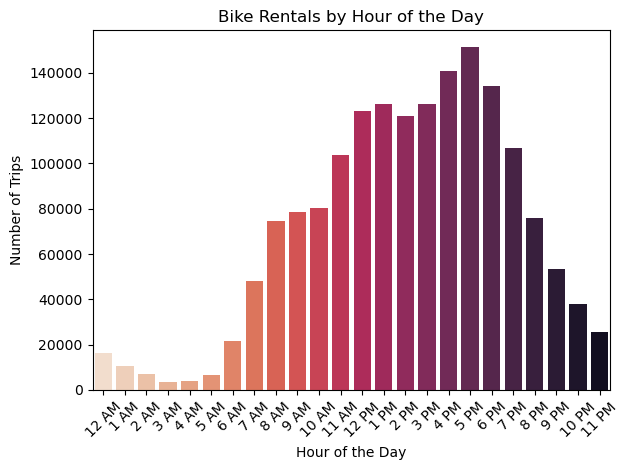

In [43]:
# converts 24-hour format to 12-hour format for the x-axis labels
def format_hour(hour):
    if hour == 0:
        return "12 AM"
    elif hour < 12:
        return f"{hour} AM"
    elif hour == 12:
        return "12 PM"
    else:
        return f"{hour - 12} PM"
    
# Gets unique hours
hours = sorted(df['hour'].unique())
hour_labels = [format_hour(hour) for hour in hours]

# plot hourly distribution 
sns.countplot(data=df, x='hour', palette='rocket_r', order=hours)
plt.title('Bike Rentals by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.xticks(ticks=range(len(hour_labels)), labels=hour_labels, rotation=45)
plt.tight_layout()
plt.savefig('hourly_distribution.png')
plt.show()

In [44]:
df['day_name'] = df['start_time'].dt.day_name()
weekly_rentals = df['day_name'].value_counts()
weekly_rentals

Friday       252304
Saturday     247700
Sunday       241137
Thursday     238975
Tuesday      237327
Wednesday    233471
Monday       226253
Name: day_name, dtype: int64

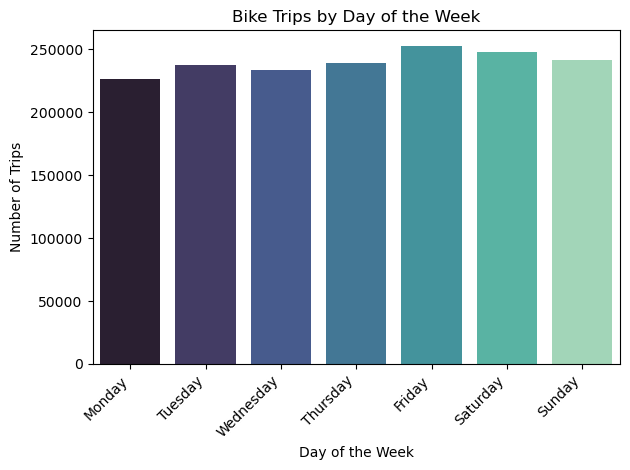

In [45]:
# day of the week distribution
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
        'Friday', 'Saturday', 'Sunday']
sns.barplot(x=weekly_rentals.index, y=weekly_rentals.values, palette='mako', order=days)
plt.title('Bike Trips by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.savefig('weekly_distribution.png')
plt.show()

In [46]:
monthly_trips = df['month'].value_counts()
monthly_trips

6     168772
10    166002
5     164596
8     148822
9     141301
7     140052
4     138470
11    133767
1     120529
3     119060
2     118400
12    117396
Name: month, dtype: int64

In [47]:
monthly_trips.max(), monthly_trips.min()

(168772, 117396)

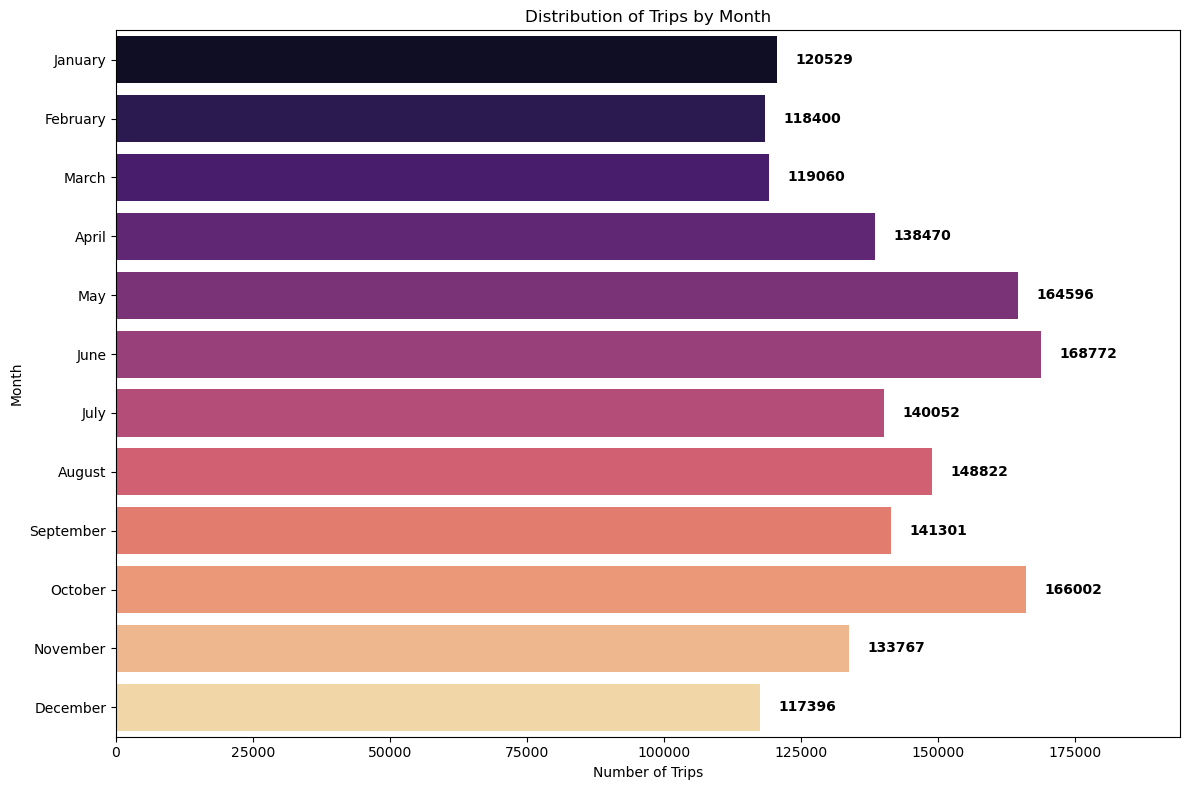

In [48]:
# monthly distribution
order_months = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 
                7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

ordered_month_names = [order_months[i] for i in range(1, 13)]

# Set the figure size for the horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(y=monthly_trips.index.map(order_months), x=monthly_trips.values, 
            palette='magma', order=ordered_month_names, ax=ax, orient='h')

# Calculate max width required for annotations
max_width_with_text = max(monthly_trips.values) + max(monthly_trips.values) * 0.15  # 15% of max value for text space

# Adjust the x-axis limits
ax.set_xlim(0, max_width_with_text)

# Placing the values next to the bars
for i, v in enumerate(monthly_trips.sort_index().values):
    ax.text(v + (max(monthly_trips.values) * 0.02), i, str(v), verticalalignment='center', color='black', fontweight='bold', fontsize=10)

plt.title('Distribution of Trips by Month')
plt.ylabel('Month')
plt.xlabel('Number of Trips')
plt.tight_layout()
plt.savefig('month_distribution_horizontal.png')
plt.show()

Here's a breakdown of the metro trip distribution:

By Month:
The trips seem to be distributed fairly evenly across months, with a noticeable dip around December. This could be due to holidays or fewer commuters during that time.
By Day of the Week:
The number of trips is relatively consistent from Monday to Friday, indicating weekday commutes. There's a noticeable drop in trips during the weekends (Saturday and Sunday), suggesting reduced commuter traffic and more leisure-based travel.
By Hour of the Day:
We observe two significant peaks: one in the morning (around 8-9 AM) and one in the evening (around 5-6 PM). These are typical rush hours when people commute to and from work or school.
The number of trips decreases significantly during the late-night hours, picking up again in the early morning.

### Station Analysis

In [49]:
df.head(2)

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station,bike_type,month,day_of_week,hour,day_name
55439,8374193,42,2016-10-01 00:38:00,2016-10-01 01:20:00,34.045422,-118.253517,34.04998,-118.247162,6075,1,One Way,Walk-up,3051,3027,Unknown,10,5,0,Saturday
55440,8369649,7,2016-10-01 00:47:00,2016-10-01 00:54:00,34.053020,-118.247948,34.04652,-118.237411,5823,1,One Way,Walk-up,3046,3082,Unknown,10,5,0,Saturday


In [50]:
# most popular start stations
top_start_station = df['start_station'].value_counts().sort_values(ascending=False).head(10)
top_start_station

3005    62172
4214    58064
4210    40255
3030    39506
3014    37118
3031    37109
3035    36907
4215    36845
3064    32763
3006    29279
Name: start_station, dtype: int64

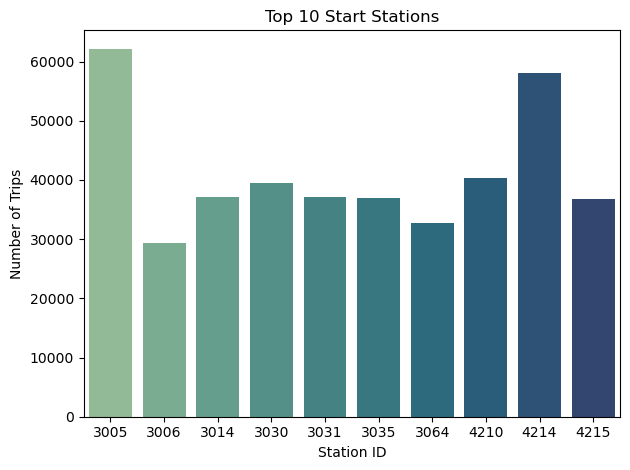

In [51]:
# start station plot
sns.barplot(x=top_start_station.index, y=top_start_station.values,
            palette='crest')
plt.title('Top 10 Start Stations')
plt.xlabel('Station ID')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

In [52]:
# most popular end stations
top_end_station = df['end_station'].value_counts().sort_values(ascending=False).head(10)
top_end_station

3005    67155
4215    56755
4214    49614
3014    41409
3031    39943
3035    38534
4210    38211
3030    34576
3064    33552
3082    30410
Name: end_station, dtype: int64

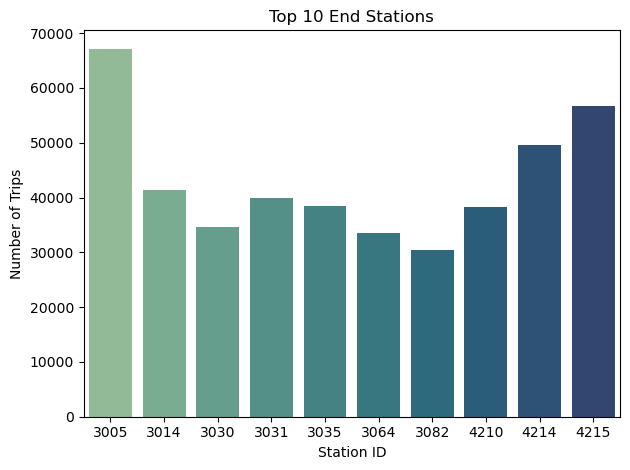

In [53]:
# start station plot
sns.barplot(x=top_end_station.index, y=top_end_station.values,
            palette='crest')
plt.title('Top 10 End Stations')
plt.xlabel('Station ID')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

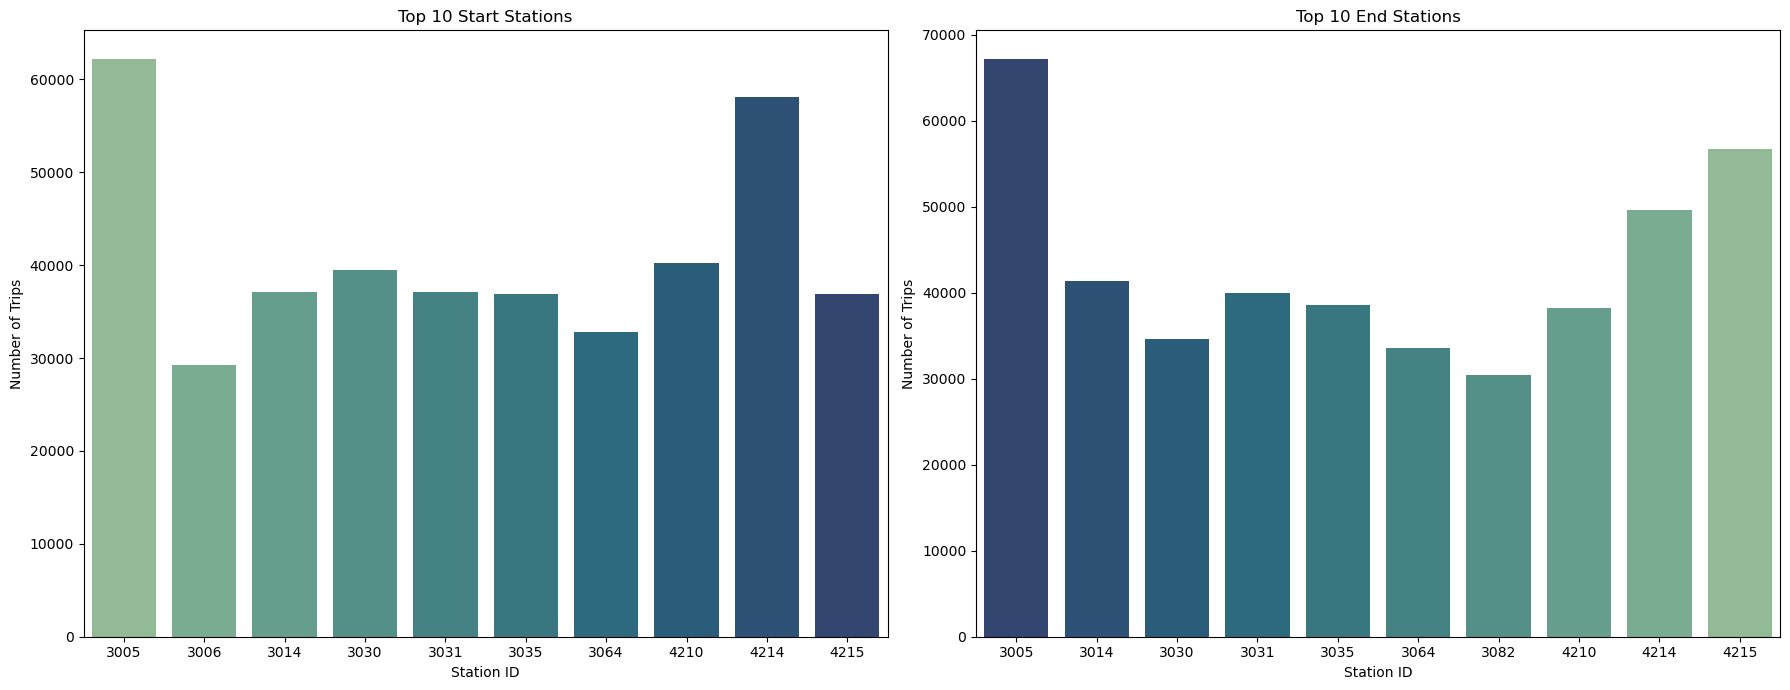

In [54]:
# Setting up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Plotting the top start stations on the left axis
sns.barplot(x=top_start_station.index, y=top_start_station.values, ax=axes[0], palette='crest')
axes[0].set_title('Top 10 Start Stations')
axes[0].set_xlabel('Station ID')
axes[0].set_ylabel('Number of Trips')

# Plotting the top end stations on the right axis
sns.barplot(x=top_end_station.index, y=top_end_station.values, ax=axes[1], palette='crest_r')
axes[1].set_title('Top 10 End Stations')
axes[1].set_xlabel('Station ID')
axes[1].set_ylabel('Number of Trips')

# Adjusting the layout
plt.tight_layout()
plt.savefig('top_stations_combined.png')
plt.show()

Here's the analysis of the top start and end stations:

Top Start Stations:
The bar chart shows the ten most popular start stations based on the number of trips initiated from them. Some stations experience significantly higher traffic than others, indicating key commuter hubs or popular locations.
Top End Stations:
Similar to start stations, the chart showcases the ten most frequented end stations. These are locations where most trips conclude, which could be due to popular destinations, commercial areas, or transit hubs.

#### Stations with high departure but low arrival rates.

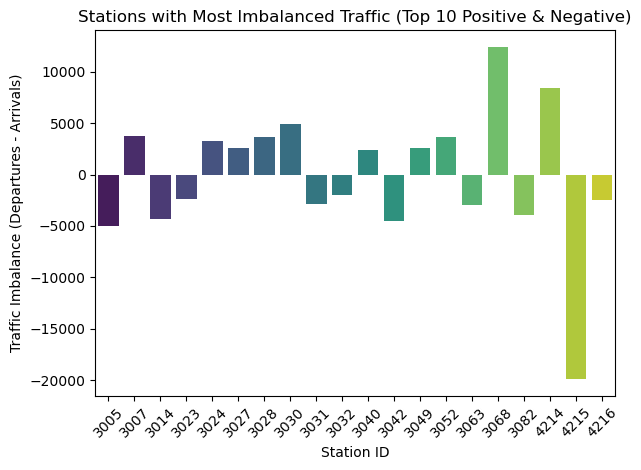

In [55]:
# Calculating the number of departures and arrivals for each station
departures = df['start_station'].value_counts()
arrivals = df['end_station'].value_counts()

# Merging the departures and arrivals into a single dataframe
station_traffic = pd.concat([departures, arrivals], axis=1, keys=['Departures', 'Arrivals']).fillna(0)

# Calculating the imbalance for each station
station_traffic['Imbalance'] = station_traffic['Departures'] - station_traffic['Arrivals']

# Sorting the stations by imbalance
station_traffic_sorted = station_traffic.sort_values(by='Imbalance', ascending=False)

# Getting the top 10 stations with the most positive and negative imbalances
top_imbalance = pd.concat([station_traffic_sorted.head(10), station_traffic_sorted.tail(10)])

# Plotting the stations with the most imbalanced traffic

sns.barplot(x=top_imbalance.index, y=top_imbalance['Imbalance'], palette='viridis')
plt.title('Stations with Most Imbalanced Traffic (Top 10 Positive & Negative)')
plt.xlabel('Station ID')
plt.ylabel('Traffic Imbalance (Departures - Arrivals)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('imbalanced_traffic.png')
plt.show()

The bar chart showcases the stations with the most imbalanced traffic:

Positive Imbalance (left side of the chart): Stations with more departures than arrivals. These stations have a higher number of trips starting from them compared to trips ending at them. This might indicate residential areas where people start their daily commutes.

Negative Imbalance (right side of the chart): Stations with more arrivals than departures. These stations have a higher number of trips ending at them than starting from them. This might suggest commercial areas or popular destinations where people travel to.

### Duration Analysis

In [56]:
route_category_counts = df['trip_route_category'].value_counts()
route_category_counts

One Way       1379372
Round Trip     297795
Name: trip_route_category, dtype: int64

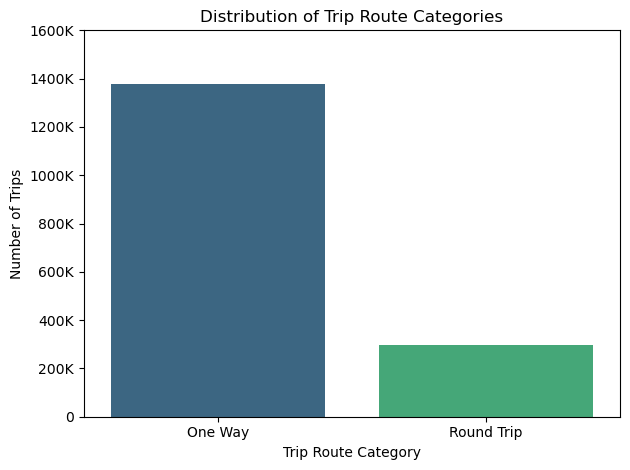

In [57]:
sns.countplot(data=df, x=df['trip_route_category'], palette="viridis")
plt.title('Distribution of Trip Route Categories')
plt.xlabel('Trip Route Category')
plt.ylabel('Number of Trips')
plt.yticks(ticks=plt.gca().get_yticks(), labels=[f'{int(val/1000)}K' if val > 0 else '0' for val in plt.gca().get_yticks()])
plt.tight_layout()
plt.savefig('trip_route_distribution.png')
plt.show()

In [58]:
# distribution of trip durations.
# long durations from specific start stations

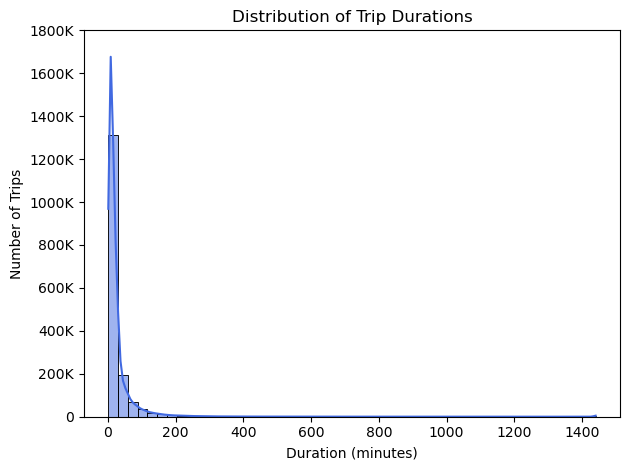

In [59]:
# plot the overall distribution of trip durations

sns.histplot(df['duration'], bins=50, kde=True, color='royalblue')

plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Number of Trips')
plt.yticks(ticks=plt.gca().get_yticks(), labels=[f'{int(val/1000)}K' if val > 0 else '0' for val in plt.gca().get_yticks()])
plt.tight_layout()
plt.savefig('duration_distribution.png')
plt.show()

The histogram showcases the distribution of trip durations:

Most trips are of short duration, with a peak around 5-15 minutes.
The distribution is right-skewed, indicating that while most trips are short, there are a few trips that are considerably longer.
The long tail suggests that there are occasional trips that last for an extended period, although they are relatively rare.

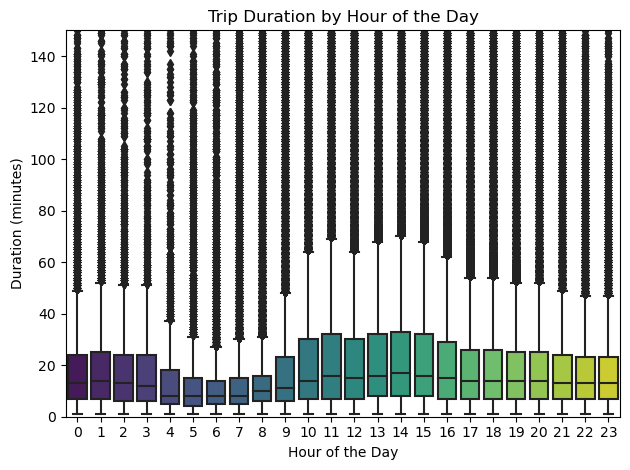

In [60]:
# plot tip duration by hour of the day
sns.boxplot(x=df['hour'], y=df['duration'], palette='viridis')
plt.title('Trip Duration by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Duration (minutes)')
plt.ylim(0, 150)  # filter outliers for better visualization
plt.tight_layout()
plt.savefig('trip_duration_hourly.png')
plt.show()

The boxplot illustrates trip durations by the hour of the day:

For most hours, the median trip duration lies between 5 to 15 minutes.
Late-night hours (from around 23:00 to 5:00) show a slightly higher median duration compared to other times. This might be because of fewer services during these hours, requiring passengers to take longer routes or trips.
There are outliers in trip durations across all hours, indicating occasional long trips throughout the day.

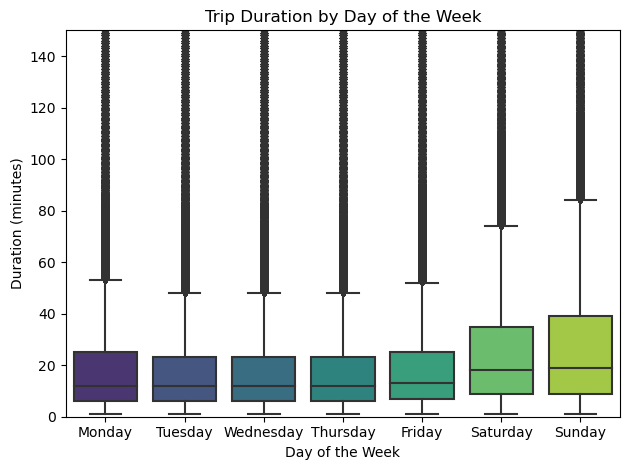

In [61]:
# plot trip duration by day of the week
sns.boxplot(x=df['day_of_week'], y=df['duration'], palette='viridis')

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(ticks=range(7), labels=days)

plt.title('Trip Duration by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Duration (minutes)')
plt.ylim(0, 150)  # filter outliers for better visualization
plt.tight_layout()
plt.savefig('trip_duration_dayweek')
plt.show()

The boxplot showcases trip durations by the day of the week:

The median trip duration remains fairly consistent across all days, ranging between 5 to 15 minutes.
Weekends (Saturday and Sunday) have a slightly more varied range of durations compared to weekdays. This can be observed from the wider interquartile range (IQR) for these days.
The presence of outliers across all days indicates that there are occasional long trips regardless of the day.

Most metro trips are of short duration, regardless of the time or day.
Late-night trips tend to be slightly longer, possibly due to reduced services.
Weekend trips exhibit a broader range of durations, suggesting a mix of short commutes and longer leisure trips.

### Passholder Type & Bike Analysis

In [62]:
# distribution of different passholder types
# bike usage patterns

In [63]:
df.head(2)

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station,bike_type,month,day_of_week,hour,day_name
55439,8374193,42,2016-10-01 00:38:00,2016-10-01 01:20:00,34.045422,-118.253517,34.04998,-118.247162,6075,1,One Way,Walk-up,3051,3027,Unknown,10,5,0,Saturday
55440,8369649,7,2016-10-01 00:47:00,2016-10-01 00:54:00,34.053020,-118.247948,34.04652,-118.237411,5823,1,One Way,Walk-up,3046,3082,Unknown,10,5,0,Saturday


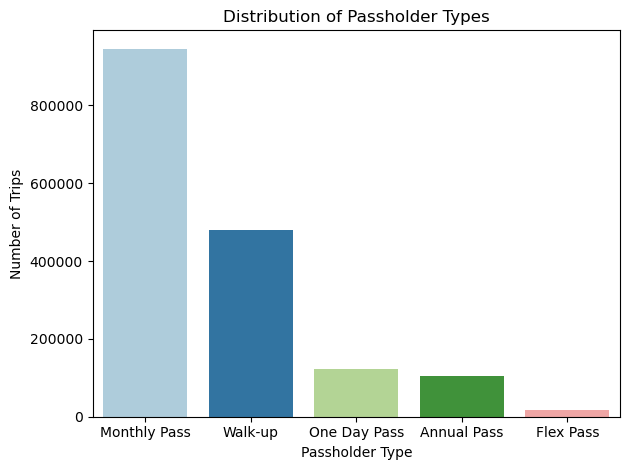

In [64]:
# Passholder type distribution
sns.countplot(data=df, x='passholder_type', palette='Paired', order=df['passholder_type'].value_counts().index)
plt.title('Distribution of Passholder Types')
plt.xlabel('Passholder Type')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.savefig('passholder_type.png')
plt.show()

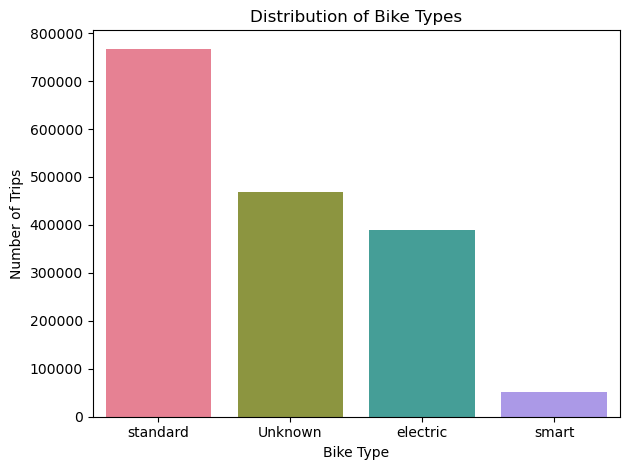

In [65]:
# Bike type distribution
sns.countplot(data=df, x='bike_type', palette='husl', order=df['bike_type'].value_counts().index)
plt.title('Distribution of Bike Types')
plt.xlabel('Bike Type')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.savefig('bike_type.png')
plt.show()

Here's the analysis of the distribution of passholder types and bike types:

Passholder Types:

The most common passholder type is "Monthly Pass", which indicates a significant number of riders who use the metro service regularly.
"Walk-up" and "One Day Pass" are the next most common types, suggesting there are also many occasional riders or tourists.
"Annual Pass" and "Flex Pass" are less frequent, but they represent long-term commitments from riders.
Bike Types:

The overwhelming majority of bikes used are of the "standard" type.
"Smart" and "Electric" bikes are less commonly used. This distribution can help in resource allocation, maintenance schedules, and future procurement decisions for the metro service.

### Geospatial Analysis

In [66]:
# Create a combined dataframe of unique start and end stations with their latitudes and longitudes
start_stations = df[['start_station', 'start_lat', 'start_lon']].drop_duplicates().rename(columns={'start_station': 'station_id', 'start_lat': 'lat', 'start_lon': 'lon'})
end_stations = df[['end_station', 'end_lat', 'end_lon']].drop_duplicates().rename(columns={'end_station': 'station_id', 'end_lat': 'lat', 'end_lon': 'lon'})
all_stations = pd.concat([start_stations, end_stations]).drop_duplicates()

# Convert the stations dataframe to a GeoDataFrame
geometry = [Point(xy) for xy in zip(all_stations['lon'], all_stations['lat'])]
geo_stations = gpd.GeoDataFrame(all_stations, geometry=geometry)

geo_stations.head()

,station_id,lat,lon,geometry
55439,3051,34.045422,-118.253517,POINT (-118.25352 34.04542)
55440,3046,34.053020,-118.247948,POINT (-118.24795 34.05302)
55441,3062,34.047749,-118.243172,POINT (-118.24317 34.04775)
55442,3063,34.048038,-118.253738,POINT (-118.25374 34.04804)
55445,3065,34.060558,-118.238327,POINT (-118.23833 34.06056)


In [67]:
# Saving the geo_stations dataframe to a CSV file
geo_stations_csv = "geo_stations.csv"
geo_stations.to_csv(geo_stations_csv, index=False)

geo_stations_csv

'geo_stations.csv'

In [68]:
geo_stations['station_id'].nunique()

410

In [69]:
# Create a base map centered around the mean latitude and longitude values of the stations
m = folium.Map(location=[geo_stations['lat'].mean(), geo_stations['lon'].mean()], zoom_start=13)

# Add each station as a marker on the map
for index, row in geo_stations.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=str(row['station_id']),
        icon=folium.Icon(icon="circle", prefix="fa", color="blue")
    ).add_to(m)
m.save("map_stations.html")
m

In [70]:
geo_stations.head()

,station_id,lat,lon,geometry
55439,3051,34.045422,-118.253517,POINT (-118.25352 34.04542)
55440,3046,34.053020,-118.247948,POINT (-118.24795 34.05302)
55441,3062,34.047749,-118.243172,POINT (-118.24317 34.04775)
55442,3063,34.048038,-118.253738,POINT (-118.25374 34.04804)
55445,3065,34.060558,-118.238327,POINT (-118.23833 34.06056)


### Define functions required for the analysis

In [71]:
# Define the haversine_distance function that calculates the distance between two points on the Earth's surface.
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert the latitudes and longitudes from degrees to radians.
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Calculate the difference in latitudes and longitudes between the two points.
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Compute the squared half-chord length between the two points using trigonometric functions.
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the central angle between the two points.
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    # Define the Earth's radius in kilometers.
    R = 6371.0
    # Calculate the distance between the two points using the Earth's radius and the central angle.
    distance = R * c
    return distance

In [72]:
# Nearest neighbor distance function
def nearest_neighbor_distance(row):
    # For each station in the 'geo_stations' DataFrame, compute the distance from the input station ('row') to that station
    # using the haversine_distance function.
    distances = geo_stations.apply(
        lambda r: haversine_distance(row['lat'], row['lon'], r['lat'], r['lon']),
        axis=1
    )
    # Filter out the distance of the station to itself, which would be zero.
    distances = distances[distances > 0]
    # Return the minimum distance from the input station to its nearest neighboring station.
    return distances.min()

In [73]:
# Calculate the nearest neighbor distance for each station
geo_stations['nearest_neighbor_distance'] = geo_stations.apply(nearest_neighbor_distance, axis=1)
geo_stations[['station_id', 'nearest_neighbor_distance']].head()

,station_id,nearest_neighbor_distance
55439,3051,0.000645
55440,3046,0.000737
55441,3062,0.000184
55442,3063,0.153689
55445,3065,0.000645


In [74]:
# IQR Threshold Calculation
geo_stations['nearest_neighbor_distance'] = geo_stations.apply(nearest_neighbor_distance, axis=1)
Q1 = geo_stations['nearest_neighbor_distance'].quantile(0.25)
Q3 = geo_stations['nearest_neighbor_distance'].quantile(0.75)
IQR = Q3 - Q1
iqr_threshold = Q3 + 1.5 * IQR

### Recommending New Stations Locations in Underserved Areas

In [75]:
# Step 1. Identify Large Gaps
stations_with_large_gaps = geo_stations[geo_stations['nearest_neighbor_distance'] > iqr_threshold]

In [76]:
# Step 2. Potential Station Locations

large_gap_midpoints = []
for _, station_data in stations_with_large_gaps.iterrows():
    distances = geo_stations.apply(
        lambda r: haversine_distance(station_data['lat'], station_data['lon'], r['lat'], r['lon']),
        axis=1
    )
    distances = distances[distances > 0]
    nearest_station_idx = distances.idxmin()
    nearest_station_data = geo_stations.loc[nearest_station_idx]
    
    midpoint_lat = (station_data['lat'] + nearest_station_data['lat']) / 2
    midpoint_lon = (station_data['lon'] + nearest_station_data['lon']) / 2
    large_gap_midpoints.append({
        'station_id': station_data['station_id'], 
        'nearest_station': nearest_station_data['station_id'], 
        'midpoint_lat': midpoint_lat, 
        'midpoint_lon': midpoint_lon
    })

large_gap_midpoints_df = pd.DataFrame(large_gap_midpoints)

In [77]:
large_gap_midpoints_df.head()

,station_id,nearest_station,midpoint_lat,midpoint_lon
0,4174,4154,34.160706,-118.151080
1,4426,4418,34.150280,-118.372509
2,4425,4422,34.152071,-118.356278
3,4432,4418,34.145128,-118.364189
4,4453,4439,34.086809,-118.285320


In [94]:
# 6. Visualize on Map
map_center_gaps = [large_gap_midpoints_df['midpoint_lat'].mean(), large_gap_midpoints_df['midpoint_lon'].mean()]
m_gaps = folium.Map(location=map_center_gaps, zoom_start=12)

for _, row in large_gap_midpoints_df.iterrows():
    folium.Marker(
        location=[row['midpoint_lat'], row['midpoint_lon']],
        tooltip=f"Potential Station Between {row['station_id']} and {row['nearest_station']}",
        icon=folium.Icon(icon='bicycle', prefix='fa', color='blue')
    ).add_to(m_gaps)

m_gaps.save("m_gaps.html")
m_gaps

### Recommending New Stations Based on Trip Durations

In [79]:
# Step 1: Calulates the average trip duartion for each station
average_durations = df.groupby('start_station')['duration'].mean()

In [80]:
# Step 2: Benchmark is set to 90th percentile of average ride durations
benchmark_duration = average_durations.quantile(0.90)

# Identifies stations with average trip duration greater than the benchmark
long_ride_stations = average_durations[average_durations > benchmark_duration].index.tolist()

In [81]:
# Step 3: For each station with lengthy average trips, find its nearest neighboring station
nearest_neighbors_duration = {}
for station in long_ride_stations:
    station_data = geo_stations[geo_stations['station_id'] == station].iloc[0]
    distances = geo_stations.apply(
        lambda r: haversine_distance(station_data['lat'], station_data['lon'], r['lat'], r['lon']),
        axis=1
    )
    distances = distances[distances > 0]
    nearest_station = distances.idxmin()
    nearest_station_id = geo_stations.loc[nearest_station, 'station_id']
    if station != nearest_station_id:
        nearest_neighbors_duration[station] = nearest_station_id

In [82]:
# Step 4: Identifies midpoints between the stations with long rides and their nearest neighbors
midpoints_duration = []
for station, nearest_station in nearest_neighbors_duration.items():
    lat1, lon1 = geo_stations[geo_stations['station_id'] == station][['lat', 'lon']].values[0]
    lat2, lon2 = geo_stations[geo_stations['station_id'] == nearest_station][['lat', 'lon']].values[0]
    midpoint_lat = (lat1 + lat2) / 2
    midpoint_lon = (lon1 + lon2) / 2
    midpoints_duration.append({
        'station_id': station, 
        'nearest_station': nearest_station, 
        'midpoint_lat': midpoint_lat, 
        'midpoint_lon': midpoint_lon
    })

midpoints_duration_df = pd.DataFrame(midpoints_duration)

In [83]:
midpoints_duration_df.head()

,station_id,nearest_station,midpoint_lat,midpoint_lon
0,4204,4503,33.989059,-118.450256
1,4210,4211,33.984634,-118.470756
2,4244,4454,34.017979,-118.289223
3,4276,4634,34.047390,-118.219219
4,4352,4503,33.989059,-118.450256


In [100]:
# Determine the center of the map based on the midpoints' latitude and longitude
map_center_duration = [midpoints_duration_df['midpoint_lat'].mean(), midpoints_duration_df['midpoint_lon'].mean()]

# Create a folium map centered around the average coordinates
m_duration = folium.Map(location=map_center_duration, zoom_start=12)

# Add markers for each midpoint
for _, row in midpoints_duration_df.iterrows():
    folium.Marker(
        location=[row['midpoint_lat'], row['midpoint_lon']],
        tooltip=f"Between Station {row['station_id']} and {row['nearest_station']}",
        icon=folium.Icon(icon='bicycle', prefix='fa', color='blue')
    ).add_to(m_duration)

# Save to HTML and return the map
m_duration.save("m_duration.html")
m_duration

### Recommending New Stations Based on Bike Imbalances

In [85]:
# Step 1: Calculate Imbalances for Each Station
pickup_counts = df['start_station'].value_counts()
dropoff_counts = df['end_station'].value_counts()
imbalance = pickup_counts.subtract(dropoff_counts, fill_value=0)

In [86]:
# Step 2: Identify Stations with Positive and Negative Imbalances
positive_imbalance_threshold = imbalance.quantile(0.75)
negative_imbalance_threshold = imbalance.quantile(0.25)
positive_imbalance_stations = imbalance[imbalance >= positive_imbalance_threshold].index.tolist()
negative_imbalance_stations = imbalance[imbalance <= negative_imbalance_threshold].index.tolist()

In [87]:
# Step 3: Find Nearest Neighbors for Imbalanced Stations
imbalance_neighbors = {}
for station in positive_imbalance_stations + negative_imbalance_stations:
    station_data = geo_stations[geo_stations['station_id'] == station].iloc[0]
    distances = geo_stations.apply(
        lambda r: haversine_distance(station_data['lat'], station_data['lon'], r['lat'], r['lon']),
        axis=1
    )
    distances = distances[distances > 0]
    nearest_station = distances.idxmin()
    nearest_station_id = geo_stations.loc[nearest_station, 'station_id']
    if station != nearest_station_id:
        imbalance_neighbors[station] = nearest_station_id

In [88]:
# Step 4: Determine Potential New Station Locations
imbalance_midpoints = []
for station, nearest_station in imbalance_neighbors.items():
    lat1, lon1 = geo_stations[geo_stations['station_id'] == station][['lat', 'lon']].values[0]
    lat2, lon2 = geo_stations[geo_stations['station_id'] == nearest_station][['lat', 'lon']].values[0]
    midpoint_lat = (lat1 + lat2) / 2
    midpoint_lon = (lon1 + lon2) / 2
    imbalance_midpoints.append({
        'station_id': station, 
        'nearest_station': nearest_station, 
        'midpoint_lat': midpoint_lat, 
        'midpoint_lon': midpoint_lon
    })

imbalance_midpoints_df = pd.DataFrame(imbalance_midpoints)

In [89]:
imbalance_midpoints_df.head()

,station_id,nearest_station,midpoint_lat,midpoint_lon
0,3024,4480,34.058340,-118.249778
1,3026,4410,34.063265,-118.271339
2,3030,3016,34.052419,-118.242546
3,3066,3078,34.063835,-118.237549
4,4151,4142,34.143474,-118.143051


In [90]:
# Create a folium map centered around the average coordinates of the imbalance midpoints
map_center = [imbalance_midpoints_df['midpoint_lat'].mean(), imbalance_midpoints_df['midpoint_lon'].mean()]
m_imbalance = folium.Map(location=map_center, zoom_start=12)

# Add markers for each midpoint of imbalance stations
for _, row in imbalance_midpoints_df.iterrows():
    color = 'green' if row['station_id'] in positive_imbalance_stations else 'purple'
    icon = 'plus' if row['station_id'] in positive_imbalance_stations else 'minus'
    folium.Marker(
        location=[row['midpoint_lat'], row['midpoint_lon']],
        tooltip=f"Between Imbalanced Station {row['station_id']} and {row['nearest_station']}",
        icon=folium.Icon(color=color, icon=icon),
    ).add_to(m_imbalance)

# Save to HTML and return the map
m_imbalance.save("m_imbalance.html")
m_imbalance